In [1]:
%%capture
import sys

is_in_colab = 'google.colab' in sys.modules

if is_in_colab:
  from google.colab import drive
  drive.mount('/content/drive')

  %cd /content/drive/MyDrive/KU_NLP
  !pip install -r requirements.txt

# 2. Representation Learning

In [85]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from enum import Enum

import fasttext
import fasttext.util

import torch
from torch import nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import compress_fasttext
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [287]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
class Annotation_error(Enum):
    UNANSWERED = -1
    BAD_TOKENIZATION_OR_DATA = -2
    IGNORED = -3

In [6]:
path_train_set = "data/train_set_stanza.pkl"
path_validation_set = "data/validation_set_stanza.pkl"

In [7]:
train_set = pd.read_pickle(path_train_set)
validation_set = pd.read_pickle(path_validation_set)

In [8]:
train_en = train_set[train_set["language"] == "english"]
train_fi = train_set[train_set["language"] == "finnish"]
train_ja = train_set[train_set["language"] == "japanese"]

validation_en = validation_set[validation_set["language"] == "english"]
validation_fi = validation_set[validation_set["language"] == "finnish"]
validation_ja = validation_set[validation_set["language"] == "japanese"]

# 2a.

In [9]:
train_en

,language,question,document_title,document,document_answer_region
0,english,"[When, was, quantum, field, theory, developed, ?]","[Quantum, field, theory]","[Quantum, field, theory, naturally, began, wit...","(26, 26)"
1,english,"[Who, was, the, first, Nobel, prize, winner, f...","[List, of, Nobel, laureates, in, Literature]","[The, Nobel, Prize, in, Literature, (, Swedish...","(12, 13)"
2,english,"[When, is, the, dialectical, method, used, ?]",[Dialectic],"[Dialectic, or, dialectics, (, Greek, :, διαλε...","(27, 49)"
3,english,"[Who, invented, Hangul, ?]","[Origin, of, Hangul]","[Hangul, was, personally, created, and, promul...","(16, 18)"
4,english,"[What, do, Grasshoppers, eat, ?]",[Grasshopper],"[Grasshoppers, are, plant, -, eaters, ,, with,...","(1, 37)"
...,...,...,...,...,...
7384,english,"[What, was, Neil, Brooks, ', fastest, recorded...","[Swimming, at, the, 1980, Summer, Olympics, –,...","[The, medley, relay, was, scheduled, in, the, ...",Annotation_error.UNANSWERED
7385,english,"[Who, are, the, three, most, important, easter...","[Eastern, philosophy]","[Sāmkhya, is, a, dualist, philosophical, tradi...",Annotation_error.UNANSWERED
7386,english,"[Who, was, costume, designer, for, the, first,...","[John, Mollo]","[Mollo, was, surprised, by, the, success, of, ...",Annotation_error.UNANSWERED
7387,english,"[Who, developed, the, first, thermonuclear, we...","[History, of, nuclear, weapons]","[In, the, end, ,, President, Truman, made, the...",Annotation_error.UNANSWERED


In [10]:
# If the question is answered, then predict "1". Otherwise predict "0".
def get_target(data):
    answer_set = data['document_answer_region']
    y = np.empty(answer_set.shape[0], dtype=np.int32)

    for i, answer in enumerate(answer_set):
        if type(answer) == Annotation_error and answer == Annotation_error.UNANSWERED: # @TODO: if we don't do the annotation stuff, then we can check for -1 here
            y[i] = 0
        else:
            y[i] = 1
    return y

In [186]:
def token_to_id(token, tok2vec):
    assert OOV_id != None

    try:
        id = tok2vec.get_index(token)
    except:
        id = OOV_id # OOV
    return id

In [187]:
def prepare_sample(question_tokens, document_tokens, tok2vec, question_max_length=512, document_max_length=1024):
    question_ids = [token_to_id(token, tok2vec) for token in question_tokens[:question_max_length]]
    document_ids = [token_to_id(token, tok2vec) for token in document_tokens[:document_max_length]]
    return question_ids, len(question_ids), document_ids, len(document_ids)

In [312]:
def pad_tokens(token_ids, token_lengths): # in a batch
    assert pad_id != None
    
    max_length = max(token_lengths)
    padded_ids = [(ids + [pad_id] * (max_length - len(ids))) for ids in token_ids]
    
    assert (all(len(padded) == max_length for padded in padded_ids))
    
    return padded_ids

def collate_into_batch(raw_batch):
    question_tokens = [sample[0] for sample in raw_batch]
    question_lengths = [sample[1] for sample in raw_batch]
    question_ids = pad_tokens(question_tokens, question_lengths)
    
    document_tokens = [sample[2] for sample in raw_batch]
    document_lengths = [sample[3] for sample in raw_batch]
    document_ids = pad_tokens(document_tokens, document_lengths)
    
    targets = [sample[4] for sample in raw_batch]

    return torch.tensor(question_ids), torch.tensor(question_lengths), torch.tensor(document_ids), torch.tensor(document_lengths), torch.tensor(targets, dtype=torch.long)

In [313]:
class QuestionAnsweredDatasetReader(Dataset):
    
    def __init__(self, df, tok2vec):
        self.df = df
        self.tok2vec = tok2vec
        self.targets = get_target(df)
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.values[idx]
        question_tokens = row[1]
        document_tokens = row[3]
        target = self.targets[idx]
        
        question_ids, question_lengths, document_ids, document_lengths = prepare_sample(question_tokens, document_tokens, self.tok2vec)
        
        return question_ids, question_lengths, document_ids, document_lengths, target

In [314]:
class LSTM_Network(nn.Module):

    def __init__(self, pretrained_embeddings: torch.tensor, lstm_dim: int = 100, n_classes: int = 2):
        super(LSTM_Network, self).__init__()
        
        self.word_embeddings = nn.Embedding.from_pretrained(pretrained_embeddings)
        self.lstm = nn.LSTM(pretrained_embeddings.shape[1], lstm_dim, batch_first=True)
        self.linear = nn.Linear(2*lstm_dim, n_classes)

    def forward(self, q_ids, q_lengths, d_ids, d_lengths):
        q_embeds = self.word_embeddings(q_ids)
        lstm_out, _ = self.lstm(q_embeds)
        q_ff_in = torch.max(lstm_out, 1)[0]
        
        d_embeds = self.word_embeddings(d_ids)
        lstm_out, _ = self.lstm(d_embeds)
        d_ff_in = torch.max(lstm_out, 1)[0]
        
        ff_in = torch.cat((q_ff_in, d_ff_in), dim=-1)
        
        logits = self.linear(ff_in)
        return logits


In [404]:
class BiLSTM_Network(nn.Module):

    def __init__(self, pretrained_embeddings: torch.tensor, lstm_dim: int = 100, n_classes: int = 2):
        super(BiLSTM_Network, self).__init__()

        self.lstm_dim = lstm_dim
        self.n_classes = n_classes
        
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=pretrained_embeddings.shape[0] - 1)
        self.biLSTM = nn.LSTM(pretrained_embeddings.shape[1], lstm_dim, 1, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(2*2*lstm_dim, n_classes)
        
    def forward(self, q_ids, q_lengths, d_ids, d_lengths):
        q_embeds = self.embedding(q_ids)
        lstm_in = nn.utils.rnn.pack_padded_sequence(q_embeds, q_lengths, batch_first=True, enforce_sorted=False)
        lstm_out, _hidden = self.biLSTM(lstm_in)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        q_ff_in = torch.max(lstm_out, 1)[0]

        d_embeds = self.embedding(d_ids)
        lstm_in = nn.utils.rnn.pack_padded_sequence(d_embeds, d_lengths, batch_first=True, enforce_sorted=False)
        lstm_out, _hidden = self.biLSTM(lstm_in)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        d_ff_in = torch.max(lstm_out, 1)[0]

        ff_in = torch.cat((q_ff_in, d_ff_in), dim=-1)
        
        logits = self.linear(ff_in)
        
        return logits

In [405]:
def prepare_embedding_matrix(embed_matrix):
    embed_dim = embed_matrix.shape[1]
    pad = torch.zeros(embed_dim, dtype=torch.float32)
    OOV = torch.zeros(embed_dim, dtype=torch.float32)
    embed_pre = torch.tensor(embed_matrix, dtype=torch.float32)
    
    OOV_id = embed_pre.shape[0]           
    pad_id = embed_pre.shape[0] + 1
                 
    return torch.vstack((embed_pre, pad, OOV)), pad_id, OOV_id

In [406]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [407]:
device

device(type='cpu')

In [408]:
# Setup Model

tok2vec = compress_fasttext.models.CompressedFastTextKeyedVectors.load("fasttext-en-mini")
pretrained_embeddings, pad_id, OOV_id = prepare_embedding_matrix(tok2vec.get_normed_vectors())

model = BiLSTM_Network(pretrained_embeddings)
model.to(device)

print(model)

BiLSTM_Network(
  (embedding): Embedding(20002, 300, padding_idx=20001)
  (biLSTM): LSTM(300, 100, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=400, out_features=2, bias=True)
)


In [409]:
def test_forward_pass(model: nn.Module):
    """
    A simple function to quickly debug the net
    """
    # Test the forward pass with dummy data
    q = torch.tensor([[42, 1, 8, 0]], dtype=torch.int)
    q_lengths = torch.tensor([3], dtype=torch.int)
    d = torch.tensor([[42, 1, 8, 0]], dtype=torch.int)
    d_lengths = torch.tensor([3], dtype=torch.int)

    out = model.forward(q, q_lengths, d, d_lengths)

    print("Output shape:", out.size())
    print(f"Output probabilities:\n{out.detach().numpy()}")

In [410]:
test_forward_pass(model)

Output shape: torch.Size([1, 2])
Output probabilities:
[[-0.05225409  0.05980343]]


In [411]:
def summarize_batch(token_ids, sequence_lengths):
    actual_length = torch.sum(sequence_lengths)
    total_length = np.sum([len(question) for question in token_ids])
    
    OOV_count = np.sum([torch.sum(question == OOV_id) for question in token_ids])
    print("OOV: {}/{}".format(OOV_count, total_length))
    
    pad_count = np.sum([torch.sum(question == pad_id) for question in token_ids])
    print("PAD: {}/{}".format(pad_count, total_length))
    

In [412]:
def evaluate(model: nn.Module, valid_dl: DataLoader):
    model.eval()

    logits_all = []
    targets_all = []
    
    with torch.no_grad():
        for q_ids, q_lengths, d_ids, d_lengths, targets in valid_dl:
            logits = model(q_ids, q_lengths, d_ids, d_lengths)
            targets_all.extend(list(targets.detach().cpu().numpy()))
            
            predictions = logits.max(1)[1]
            logits_all.extend(predictions)
            
        acc = accuracy_score(logits_all, targets_all)

    return acc

In [413]:
# Define hyper parameters
batch_size = 64
n_epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters()) #, weight_decay=1e-6

# Load dataset
train_dataset = QuestionAnsweredDatasetReader(train_en, tok2vec)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_into_batch)

val_dataset = QuestionAnsweredDatasetReader(validation_en, tok2vec)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_into_batch)

# store improvement per epoch
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(n_epochs):

    ### Training
    model.train()
    
    # Store batch loss and accuracy
    loss_epoch = []
    accuracy_epoch = []
    
    batch_pbar = tqdm(train_dataloader)
    for q_ids, q_lengths, d_ids, d_lengths, targets in batch_pbar:
        
        # training
        outputs = model(q_ids, q_lengths, d_ids, d_lengths)
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # prediction
        predictions = outputs.max(1)[1]
        accuracy = accuracy_score(targets, predictions)
        
        loss_epoch.append(loss.item())
        accuracy_epoch.append(accuracy)
        
        batch_pbar.set_description(f"epoch={epoch+1}/{n_epochs} | loss={loss.item():.2f}, accuracy={accuracy:.2f}")
        
    train_loss = np.mean(loss_epoch)
    train_losses.append(train_loss)
    
    train_acc = np.mean(accuracy_epoch)
    train_accuracies.append(train_acc)
    
    ### Evaluation
    test_acc = evaluate(model, train_dataloader)
    test_accuracies.append(test_acc)
    
    print(f"epoch={epoch+1}/{n_epochs} | loss={train_loss:.2f}, train_accuracy={train_acc:.2f}, test_accuracy={test_acc:.2f}")
    
print("Finished training.")


epoch=1/5 | loss=0.55, accuracy=0.76: 100%|██████████████████████████████████████████| 116/116 [20:45<00:00, 10.73s/it]


epoch=1/5 | loss=0.66, train_accuracy=0.60, test_accuracy=0.72


epoch=2/5 | loss=0.40, accuracy=0.86: 100%|██████████████████████████████████████████| 116/116 [21:02<00:00, 10.89s/it]


epoch=2/5 | loss=0.58, train_accuracy=0.71, test_accuracy=0.72


epoch=3/5 | loss=0.42, accuracy=0.83: 100%|██████████████████████████████████████████| 116/116 [20:49<00:00, 10.77s/it]


epoch=3/5 | loss=0.51, train_accuracy=0.76, test_accuracy=0.77


epoch=4/5 | loss=0.37, accuracy=0.86: 100%|██████████████████████████████████████████| 116/116 [20:51<00:00, 10.79s/it]


epoch=4/5 | loss=0.47, train_accuracy=0.78, test_accuracy=0.80


epoch=5/5 | loss=0.47, accuracy=0.79: 100%|██████████████████████████████████████████| 116/116 [20:33<00:00, 10.63s/it]


epoch=5/5 | loss=0.46, train_accuracy=0.79, test_accuracy=0.80
Finished training.


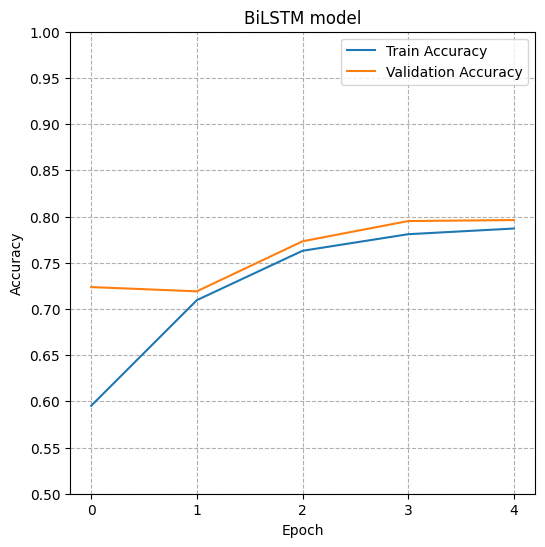

In [414]:
fig, ax = plt.subplots(figsize=(6,6))
ax.grid(linestyle="--")
ax.set_title("BiLSTM model")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")

epoch_range = np.arange(n_epochs, step=1)
ax.plot(epoch_range, train_accuracies)
ax.plot(epoch_range, test_accuracies)
ax.legend(['Train Accuracy','Validation Accuracy'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

ax.set_yticks(np.linspace(0.5, 1, 11))
ax.set_xticks(epoch_range);

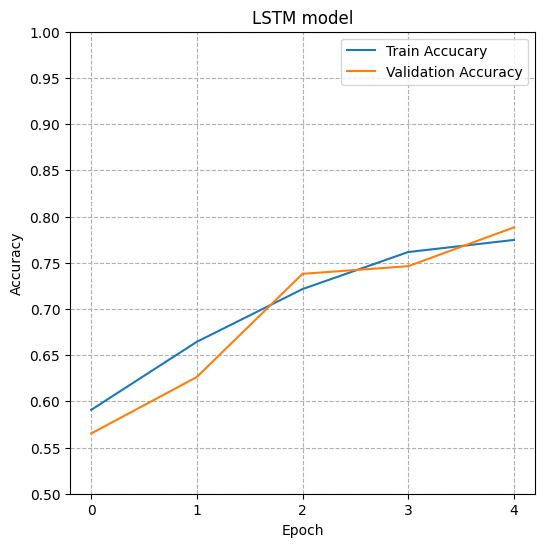

In [393]:
fig, ax = plt.subplots(figsize=(6,6))
ax.grid(linestyle="--")
ax.set_title("LSTM model")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")

epoch_range = np.arange(n_epochs, step=1)
ax.plot(epoch_range, train_accuracies)
ax.plot(epoch_range, test_accuracies)
ax.legend(['Train Accuracy','Validation Accuracy'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

ax.set_yticks(np.linspace(0.5, 1, 11))
ax.set_xticks(epoch_range);

# Prepare data

# Model

# 2b.

In [36]:
ft = fasttext.load_model('cc.en.300.bin')

In [37]:
ft.get_dimension()
ft.get_word_vector('king').shape

fasttext.util.reduce_model(ft, 80)
ft.get_dimension()

"asdasdsad" in ft.words
ft.get_nearest_neighbors('cookie')

[(0.8153295516967773, 'cupcake'),
 (0.7879170179367065, 'cookie-'),
 (0.7691606879234314, 'cookies'),
 (0.760718047618866, 'cake'),
 (0.7547473907470703, 'popover'),
 (0.7430337071418762, 'non-cookie'),
 (0.7359125018119812, 'cakepop'),
 (0.7353752255439758, 'muffin'),
 (0.7349858283996582, 'cookie.'),
 (0.7314939498901367, 'cookie.The')]

In [38]:
import spacy

In [39]:
nlp = spacy.load('en_core_web_md')

In [40]:
nlp.vocab["old"].vector.shape

(300,)

In [41]:
help(nlp)

Help on English in module spacy.lang.en object:

class English(spacy.language.Language)
 |  English(vocab: Union[spacy.vocab.Vocab, bool] = True, *, max_length: int = 1000000, meta: Dict[str, Any] = {}, create_tokenizer: Union[Callable[[ForwardRef('Language')], Callable[[str], spacy.tokens.doc.Doc]], NoneType] = None, batch_size: int = 1000, **kwargs) -> None
 |  
 |  A text-processing pipeline. Usually you'll load this once per process,
 |  and pass the instance around your application.
 |  
 |  Defaults (class): Settings, data and factory methods for creating the `nlp`
 |      object and processing pipeline.
 |  lang (str): IETF language code, such as 'en'.
 |  
 |  DOCS: https://spacy.io/api/language
 |  
 |  Method resolution order:
 |      English
 |      spacy.language.Language
 |      builtins.object
 |  
 |  Data and other attributes defined here:
 |  
 |  Defaults = <class 'spacy.lang.en.EnglishDefaults'>
 |      Language data defaults, available via Language.Defaults. Can be


https://github.com/pytorch/text/issues/1350
https://christopher5106.github.io/deep/learning/2020/04/02/fasttext_pretrained_embeddings_subword_word_representations.html

In [42]:
import compress_fasttext
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from compress_fasttext.feature_extraction import FastTextTransformer

small_model = compress_fasttext.models.CompressedFastTextKeyedVectors.load('fasttext-en-mini')

classifier = make_pipeline(
    FastTextTransformer(model=small_model), 
    LogisticRegression()
).fit(
    ['banana', 'soup', 'burger', 'car', 'tree', 'city'],
    [1, 1, 1, 0, 0, 0]
)
classifier.predict(['jet', 'train', 'cake', 'apple'])
# array([0, 0, 1, 1])

array([0, 0, 1, 1])

In [43]:
help(small_model)

Help on CompressedFastTextKeyedVectors in module compress_fasttext.compress object:

class CompressedFastTextKeyedVectors(gensim.models.fasttext.FastTextKeyedVectors)
 |  CompressedFastTextKeyedVectors(*args, **kwargs)
 |  
 |  This class extends FastTextKeyedVectors by fixing several issues:
 |  - index2word of a freshly created model is initialized from its vocab
 |  - the model does not keep heavy and useless vectors_ngrams_norm
 |  - word_vec() method with use_norm applies normalization in the right place
 |  
 |  Method resolution order:
 |      CompressedFastTextKeyedVectors
 |      gensim.models.fasttext.FastTextKeyedVectors
 |      gensim.models.keyedvectors.KeyedVectors
 |      gensim.utils.SaveLoad
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *args, **kwargs)
 |      Vectors and vocab for :class:`~gensim.models.fasttext.FastText`.
 |      
 |      Implements significant parts of the FastText algorithm.  For example,
 |      the :func:`word_ve

In [44]:
small_model.get_normed_vectors().shape

(20000, 300)

In [45]:
small_model.get_index("slap")

15784

In [46]:
small_model.most_similar("quantum")

[('Quantum', 0.5923356945161),
 ('physics', 0.4987263608889812),
 ('computational', 0.4833229306372649),
 ('cosmic', 0.46287664812730667),
 ('atomic', 0.4555259364535978),
 ('atoms', 0.4543258391303013),
 ('electron', 0.4415847215404407),
 ('electromagnetic', 0.4342020722504953),
 ('optical', 0.4341506741975586),
 ('physicist', 0.43388256332181196)]

In [47]:
small_model["sailor"].shape

(300,)

In [48]:
help(tok2vec)

Help on CompressedFastTextKeyedVectors in module compress_fasttext.compress object:

class CompressedFastTextKeyedVectors(gensim.models.fasttext.FastTextKeyedVectors)
 |  CompressedFastTextKeyedVectors(*args, **kwargs)
 |  
 |  This class extends FastTextKeyedVectors by fixing several issues:
 |  - index2word of a freshly created model is initialized from its vocab
 |  - the model does not keep heavy and useless vectors_ngrams_norm
 |  - word_vec() method with use_norm applies normalization in the right place
 |  
 |  Method resolution order:
 |      CompressedFastTextKeyedVectors
 |      gensim.models.fasttext.FastTextKeyedVectors
 |      gensim.models.keyedvectors.KeyedVectors
 |      gensim.utils.SaveLoad
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *args, **kwargs)
 |      Vectors and vocab for :class:`~gensim.models.fasttext.FastText`.
 |      
 |      Implements significant parts of the FastText algorithm.  For example,
 |      the :func:`word_ve